In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 normalization
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 normalization
])

In [3]:
# CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root=' ./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Split training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Data Loaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2)

In [4]:
def imshow(img):
    """Show an image"""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


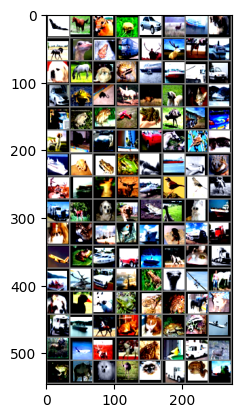

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

## CNN MODEL

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
custom_cnn = CustomCNN()
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

custom_cnn.to(device)
custom_cnn

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [10]:
import copy


def train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    num_epochs=25,
):
    """Train the model and return the best version based on validation accuracy."""

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.float() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.float() / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc.item())

        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}"
        )

        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step()

    print(f"Best validation accuracy: {best_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curves")
    plt.legend()
    plt.show()

    return model, best_acc, train_losses, val_losses, train_accuracies, val_accuracies

In [11]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [10]:
criterion_custom_cnn = nn.CrossEntropyLoss()
optimizer_custom_cnn = torch.optim.Adam(custom_cnn.parameters(), lr=0.001)
scheduler_custom_cnn = torch.optim.lr_scheduler.StepLR(optimizer_custom_cnn, step_size=7, gamma=0.1)

Epoch 1/35, Train Loss: 1.4771, Train Acc: 0.4613, Val Loss: 1.1908, Val Acc: 0.5662
Epoch 2/35, Train Loss: 1.1039, Train Acc: 0.6065, Val Loss: 1.0702, Val Acc: 0.6218
Epoch 3/35, Train Loss: 0.9563, Train Acc: 0.6605, Val Loss: 1.0061, Val Acc: 0.6401
Epoch 4/35, Train Loss: 0.8707, Train Acc: 0.6905, Val Loss: 0.8737, Val Acc: 0.6917
Epoch 5/35, Train Loss: 0.8073, Train Acc: 0.7150, Val Loss: 0.8210, Val Acc: 0.7124
Epoch 6/35, Train Loss: 0.7607, Train Acc: 0.7282, Val Loss: 0.8510, Val Acc: 0.7063
Epoch 7/35, Train Loss: 0.7238, Train Acc: 0.7444, Val Loss: 0.7854, Val Acc: 0.7243
Epoch 8/35, Train Loss: 0.6177, Train Acc: 0.7832, Val Loss: 0.6548, Val Acc: 0.7710
Epoch 9/35, Train Loss: 0.5953, Train Acc: 0.7917, Val Loss: 0.6363, Val Acc: 0.7765
Epoch 10/35, Train Loss: 0.5812, Train Acc: 0.7948, Val Loss: 0.6285, Val Acc: 0.7806
Epoch 11/35, Train Loss: 0.5736, Train Acc: 0.8005, Val Loss: 0.6192, Val Acc: 0.7795
Epoch 12/35, Train Loss: 0.5681, Train Acc: 0.8014, Val Loss: 0

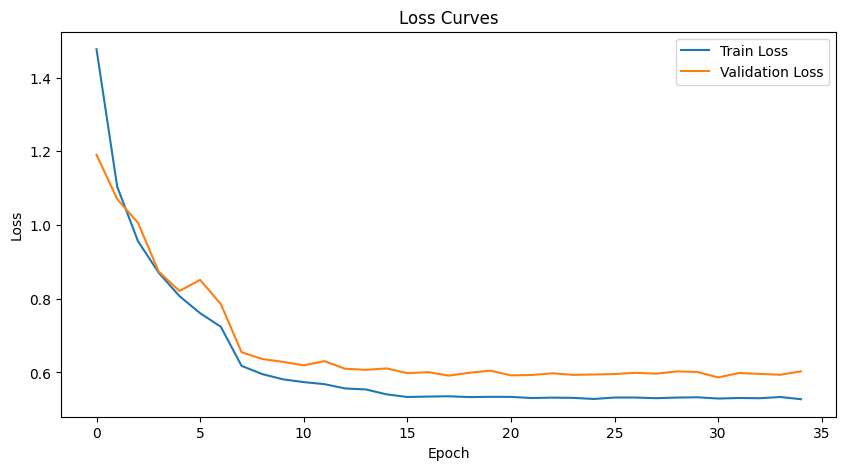

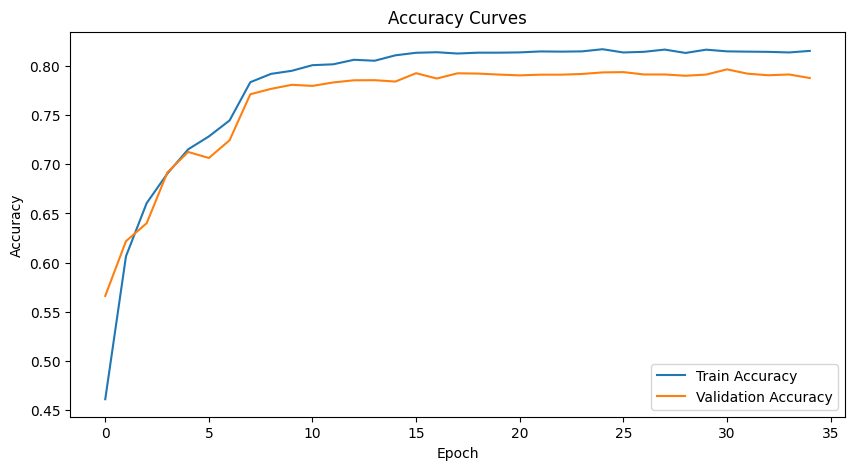

AttributeError: 'tuple' object has no attribute 'state_dict'

In [11]:
custom_cnn = train_model(
    custom_cnn,
    criterion_custom_cnn,
    optimizer_custom_cnn,
    scheduler_custom_cnn,
    trainloader,
    valloader,
    num_epochs=35,
)

In [19]:
custom_cnn = custom_cnn[0]
torch.save(custom_cnn.state_dict(), "custom_cnn_mps.pth")

In [8]:
custom_cnn.load_state_dict(torch.load("custom_cnn_mps.pth"))

<All keys matched successfully>

In [12]:
accuracy_custom_cnn = evaluate_model(custom_cnn, testloader)
print(f"Custom CNN Accuracy: {accuracy_custom_cnn:.2f}%")

Custom CNN Accuracy: 80.53%


In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


def plot_confusion_matrix(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


def print_classification_report(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(classification_report(all_labels, all_preds, target_names=classes))

In [14]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Custom CNN Classification Report:
              precision    recall  f1-score   support

       plane       0.81      0.83      0.82      1000
         car       0.91      0.91      0.91      1000
        bird       0.74      0.69      0.71      1000
         cat       0.67      0.59      0.63      1000
        deer       0.77      0.81      0.79      1000
         dog       0.69      0.73      0.71      1000
        frog       0.82      0.86      0.84      1000
       horse       0.86      0.84      0.85      1000
        ship       0.91      0.90      0.90      1000
       truck       0.87      0.89      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.80      0.81      0.80     10000
weighted avg       0.80      0.81      0.80     10000

Custom CNN Confusion Matrix:


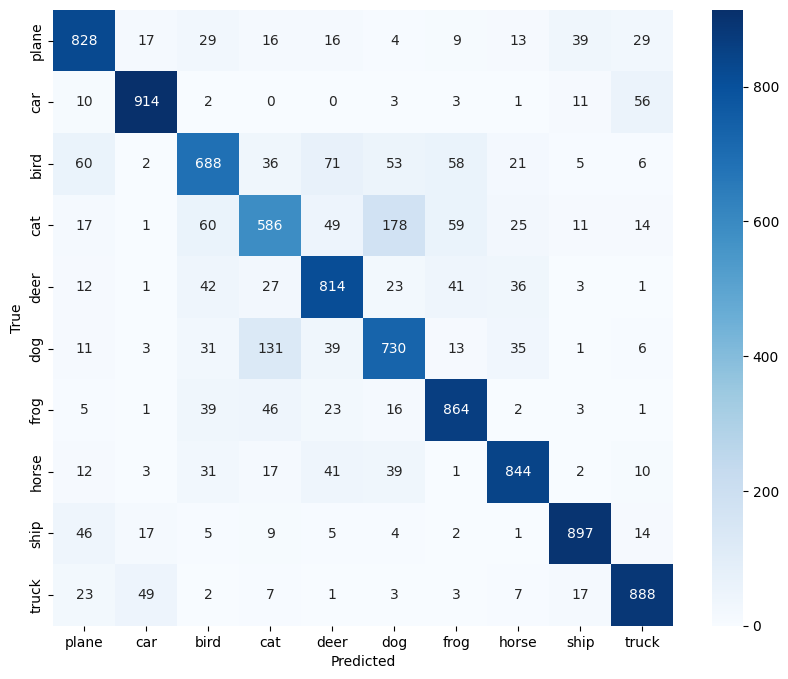

In [15]:
print("Custom CNN Classification Report:")
print_classification_report(custom_cnn, testloader, classes)
print("Custom CNN Confusion Matrix:")
plot_confusion_matrix(custom_cnn, testloader, classes)

In [16]:
def visualize_predictions(model, dataloader, classes, num_images=5):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {classes[preds[j]]}, True: {classes[labels[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images * 2:
                    return

Custom CNN Sample Predictions and Misclassifications:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5885309..1.8476002].


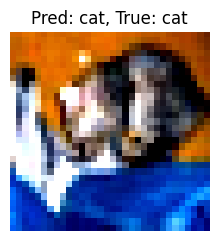

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7988244].


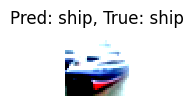

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.675763..1.8476002].


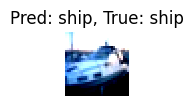

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38462442..1.6720076].


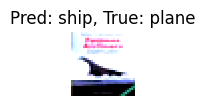

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6466857..1.4542255].


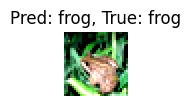

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6697937..1.330576].


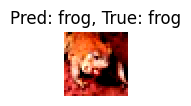

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7048404..1.8768656].


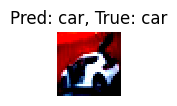

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5229002..1.8573554].


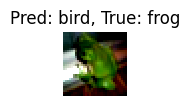

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5517926..1.7590615].


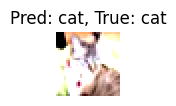

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.51245904..1.8378451].


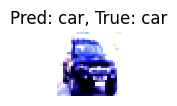

In [17]:
print("Custom CNN Sample Predictions and Misclassifications:")
visualize_predictions(custom_cnn, testloader, classes)

In [18]:
import time


def measure_inference_speed(model, dataloader, device):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time

In [19]:
inference_time_custom_cnn = measure_inference_speed(custom_cnn, testloader, device)
print(f'Custom CNN Inference Time: {inference_time_custom_cnn:.2f} seconds')


Custom CNN Inference Time: 13.10 seconds


In [20]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

In [21]:
model_size_custom_cnn = get_model_size(custom_cnn)
print(f'Custom CNN Model Size: {model_size_custom_cnn:.2f} MB')


Custom CNN Model Size: 2.37 MB
